- 1) Annual mean and maximum trend ( Mann Kendall test )
- 2) Fraction of training hours (9:00am-4:00pm MST for Yuma) that are black flag.
- 3) Trends of training hours exceding BF
- 4) Monthly trend (May to Oct ) 2 and 3
- 5) Future changes.  

https://codefornepal.org/2022/08/29/mann-kendall

In [1]:
import os.path
import numpy as np
import xarray as xr
import datetime
#import scipy.spatial.qhull as qhull 
import pymannkendall as mk
 
from calendar import monthrange
import scipy
import scipy.spatial.qhull as qhull
from scipy import stats

import matplotlib.pyplot as plt 
import pandas as pd
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.feature as cf

sys.path.append("/glade/u/home/mingge/PYTHON")
from importlib import reload
import interp_func
reload(interp_func)
 
from interp_func import interp_weights, interpolate

In [2]:
def ax_coastlines_country(ax_s):
    ax_s.coastlines(lw=1.5, resolution='110m')
    ax_s.add_feature(cfeature.STATES.with_scale('110m'), zorder=3, linewidth=1.5, edgecolor='g')
    # mask ocean 
    ax_s.add_feature(cfeature.OCEAN, facecolor='white', zorder=1) 


In [3]:
def plot_hatches_p3(dir_o, n_year, method, vabs, vmin=0, vmax=30, n_level=11):
    '''
    method: mean_mk, max_mx, max, mean, TBFhour_training
    '''
    var_s = ['WBGT', 'GWBT']
    model_s = ['ERA5', 'CONUS404']
    
    fig = plt.figure(figsize=(22, 10))
    levels = np.linspace(vmin, vmax, n_level) 
    cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, "pad" : .05, 'aspect':40, 'label':'2 Metre Temperature Anomaly [K]'}

    # A p -value less than 0.05 (typically ≤ 0.05) 
    for nv in range(len(var_s)):
        ax = fig.add_subplot(1, 3, nv+1, projection= ccrs.PlateCarree())
        ax.set_extent([-130, -60, 25, 50])
    
        if method == 'TBFhour_training':
            var_ss =  'n_TBF'
        else:
            var_ss =  var_s[nv]
    
        # read p_value which is used for hatching (0.05)
        flnm_i = dir_o + var_s[nv] + '_' + model_s[nv] + '_annual_' + method +'_mk.nc'
        print(flnm_i)
        with xr.open_dataset(flnm_i) as dss:
            data_p = dss[var_ss][0]
            data_s = dss[var_ss][1].values
    
        if var_s[nv] == 'GWBT':
            lat_2d = dss.lat.values
            lon_2d = dss.lon.values
        else:
            lat_2d = dss.latitude.values
            lon_2d = dss.longitude.values
         
        mm = plt.contourf(lon_2d, lat_2d, data_s*(n_year-1), 
                      cmap = 'Reds', extend='both',
                      vmin = vmin, vmax = vmax, levels = levels,
                      transform=ccrs.PlateCarree())
    
        # hatching <0.05
        plt.contourf(lon_2d, lat_2d, data_p, levels=[-99, 0.05, 99],
                    colors='none', hatches=['///', '']) #, alpha=.5)
        ax.coastlines()
 
        #ax.coastlines(lw=0.5, resolution='110m')
        ax.add_feature(cfeature.STATES.with_scale('110m'), zorder=3, linewidth=0.5, edgecolor='g')
        # mask ocean 
        ax.add_feature(cfeature.OCEAN, facecolor='white', zorder=1)
        cbar = plt.colorbar(mm, orientation='horizontal', pad=0.03, extend='both')
        cbar.set_label(var_ss + ' Trend [over 40 years]')
        plt.title(model_s[nv], fontweight="bold", fontsize=14)
        
        if nv == 0:
            da_0  = data_s
            lat_0 = lat_2d
            lon_0 = lon_2d

    print('interpolate')        
    #interpolate WRF conus to ERA5 (lat_0, lon_0) grid
    lon_new, lat_new = np.meshgrid(lon_0, lat_0)
    points = np.array([lon_2d.flatten(), lat_2d.flatten()]).transpose()
    vtx, wts = interp_weights(points, np.append(lon_new.flatten()[:,None], lat_new.flatten()[:,None], axis=1)) 

    value_0 = interpolate(data_s.flatten(), vtx, wts)
    da_3 = value_0.reshape(lat_new.shape[0], lat_new.shape[1])
    da_d = (da_3 - da_0)

    # get rid of missing data of interpolated CONUS 404
    da_d = np.where(abs(da_d)<4, da_d, -99)
    data_dif = xr.DataArray(da_d, 
                    coords={'latitude': lat_0, 
                            'longitude': lon_0},
                    dims=['latitude', 'longitude'])

    ax = fig.add_subplot(1, 3, 3, projection= ccrs.PlateCarree())
    ax.set_extent([-130, -60, 25, 50])
    mm = plt.contourf(lon_new, lat_new, data_dif*(n_year-1), 
                      cmap = 'RdBu_r', extend='both',
                      vmin = -1*vabs, vmax = vabs, levels=np.linspace(-1*vabs, vabs, 10) ,
                      transform=ccrs.PlateCarree())
    
    ax.coastlines() 
    #ax.coastlines(lw=0.5, resolution='110m')
    ax.add_feature(cfeature.STATES.with_scale('110m'), zorder=3, linewidth=0.5, edgecolor='g')
    # mask ocean 
    ax.add_feature(cfeature.OCEAN, facecolor='white', zorder=1)
    cbar = plt.colorbar(mm, orientation='horizontal', pad=0.03, extend='both')
    cbar.set_label('Trend difference [over 40 years]')
    plt.title('CONUS-ERA5', fontweight="bold", fontsize=14)
    plt.show()
    

In [4]:
def plot_cartopy_p3(lat_1d, lon_1d, data_1, lat_2d, lon_2d, data_2, data_d, title_s, vmin, vmax, nlevel, v_dif, cmap, cbar_s):
    fig = plt.figure(figsize=(22, 8))
    level_s = np.linspace(vmin, vmax, nlevel) 
    level_d = np.linspace(-1*v_dif, v_dif, 10) 
    cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, "pad" : .05, 'aspect':40, 'label':'2 Metre Temperature Anomaly [K]'}
    
    for nf in range(1,4):
        ax = fig.add_subplot(1, 3, nf, projection= ccrs.PlateCarree())
     
        # Set lat/lon bounding box and feature resolutions.
        ax.set_extent([-130, -60, 25, 50])
         
        if nf==1 :
            lat_n = lat_1d
            lon_n = lon_1d
            data_n = data_1
            levels = level_s
        elif nf == 2:
            lat_n = lat_2d
            lon_n = lon_2d
            data_n = data_2
            levels = level_s
        else:
            lat_n = lat_1d
            lon_n = lon_1d
            data_n = data_d
            levels = level_d
            vmax = v_dif
            vmin = -1*v_dif
             
        mm = plt.contourf(lon_n, lat_n, data_n, 
                      cmap = cmap[nf-1], extend='both',
                      vmin = vmin, vmax = vmax, levels = levels,
                      transform=ccrs.PlateCarree())
        
        ax.coastlines()
        ax_coastlines_country(ax)
        
        cbar = plt.colorbar(mm, orientation='horizontal', pad=0.05, extend='both')    
        cbar.set_label(cbar_s)
        
        gl = ax.gridlines(draw_labels=True)   
        gl.xlines = gl.ylines = False

        plt.title(title_s[nf-1], fontweight="bold",fontsize=14)
   

#### 1st filename of ERA5 and then WRF CONUS  
def plot_clim_p3(flnm_era5, flnm_wrf, vmin, vmax, n_level, vabs, cbar_s):
    if 'slope' in flnm_era5:
        color_1d = ['Reds', 'Reds', 'RdBu_r']
        with xr.open_dataset(flnm_era5) as ds_1:
            data_1 = ds_1.WBGT*(n_year-1)
            lat_1d = ds_1.latitude
            lon_1d = ds_1.longitude
    else:
        with xr.open_dataset(flnm_era5) as ds_1:
            color_1d = ['RdBu_r', 'RdBu_r', 'RdBu_r']
            data_1 = ds_1.WBGT.sel(time=slice(year_s, year_e)).mean(dim='time')     
            lat_1d = ds_1.latitude
            lon_1d = ds_1.longitude
     
    if 'slope' in flnm_wrf:
        with xr.open_dataset(flnm_wrf) as ds_2:
            data_2 = ds_2.GWBT*(n_year-1) 
            lat_wrf = ds_2.lat.values
            lon_wrf = ds_2.lon.values
    else:
        with xr.open_dataset(flnm_wrf) as ds_2:
            data_2 = ds_2.GWBT.sel(time=slice(year_s, year_e)).mean(dim='time')
            lat_wrf = ds_2.lat.values
            lon_wrf = ds_2.lon.values
    
    #interpolate WRF conus to ERA5 grid
    lon_2d, lat_2d = np.meshgrid(lon_1d, lat_1d)
    points = np.array([lon_wrf.flatten(), lat_wrf.flatten()]).transpose()
    vtx, wts = interp_weights(points, np.append(lon_2d.flatten()[:,None], lat_2d.flatten()[:,None], axis=1)) 

    valuesi=interpolate(data_2.values.flatten(), vtx, wts)
    data_3 =  valuesi.reshape(lat_2d.shape[0], lat_2d.shape[1])
    data_d = (data_3 - data_1)
    # get rid of missing data of interpolated CONUS 404
    data_d = data_d.where(abs(data_d)<4)

    data_dif = xr.DataArray(data_d, 
                    coords={'latitude': ds_1['latitude'], 
                            'longitude': ds_1['longitude']},
                    dims=['latitude', 'longitude'])    

    
    title_1d = ['WBGT ERA5', 'GWBT CONUS404', 'CONUS404-ERA5']
    plot_cartopy_p3(lat_1d, lon_1d, data_1,lat_wrf, lon_wrf, data_2, data_dif, title_1d, vmin, vmax, n_level, vabs, color_1d, cbar_s)


#### 1  Annual mean and maximum trend through Mann Kendall test 
Original Mann-Kendall test (original_test): a nonparametric test, which does not consider serial correlation or seasonal effects.
- 1.1) ERA5

In [5]:
year_s = 1980
year_e = 2019

n_year = year_e - year_s + 1

dir_o = '/glade/campaign/mmm/c3we/mingge/DOD/'
method = ['mean', 'max']

var_s = ['GWBT', 'WGBT']
n_var = len(var_s)

In [6]:
for nm in range(len(method)):
    flnm_i = dir_o + 'WBGT_ERA5_annual_' + method[nm] + '.nc'
    flnm_o = dir_o + 'WBGT_ERA5_annual_' + method[nm]+ '_mk.nc'
    
    if os.path.exists(flnm_o):
        print(flnm_o, 'exist')
        with xr.open_dataset(flnm_o) as ds:
            #print(ds)
            data_3d = ds.WBGT
            lat_era5 = ds.latitude.values
            lon_era5 = ds.longitude.values
            n_lat_era5 = data_3d.shape[1]
            n_lon_era5 = data_3d.shape[2]
    else:
        with xr.open_dataset(flnm_i) as ds:
            #print(ds,flnm_i)
            data_3d = ds['WBGT']
            n_year = data_3d.shape[0]
            n_lat_era5 = data_3d.shape[1]
            n_lon_era5 = data_3d.shape[2]
        
        #slope_2d = np.zeros((n_lat_era5, n_lon_era5))  
        mk_3d = np.zeros((2, n_lat_era5, n_lon_era5)) 
        for ni in range(n_lat_era5):
            print(ni)
            for nj in range(n_lon_era5):
                res = mk.original_test(data_3d[:,ni, nj])
                #slope_2d[ni, nj] = np.polyfit(range(data_3d.shape[0]), data_3d[:,ni, nj],1)[0]
                mk_3d[0, ni, nj] = res.p
                mk_3d[1, ni, nj] = res.slope
         
        da = xr.DataArray(data = mk_3d,
                          coords={'mk': range(2), 'latitude': ds.latitude, 'longitude': ds.longitude}, 
                          dims=["mk", "latitude", "longitude"],
                          attrs = {'mk':'0:p_value, 1:slope', 'script':'Ming Ge: wgbt_wrf_era5_cmp_2.ipynb' })
                    
        ds = da.to_dataset(name='WBGT')         
        ds.to_netcdf(flnm_o)
        print(flnm_o)   
print('finished')

/glade/campaign/mmm/c3we/mingge/DOD/WBGT_ERA5_annual_mean_mk.nc exist
/glade/campaign/mmm/c3we/mingge/DOD/WBGT_ERA5_annual_max_mk.nc exist
finished


/glade/work/mingge/miniconda3/envs/casper_2020/lib/python3.9/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
module 'cfgrib.messages' has no attribute 'DEFAULT_INDEXPATH'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


- 1.2) WRF CONUS4  

In [7]:
for nm in range(len(method)):
    flnm_i = dir_o + 'GWBT_CONUS404_annual_' + method[nm] + '.nc'
    flnm_o = dir_o + 'GWBT_CONUS404_annual_' + method[nm]+ '_mk.nc'
    
    if os.path.exists(flnm_o):
        print(flnm_o, 'exist')
        with xr.open_dataset(flnm_o) as ds:
            print(flnm_o)
            data_3d = ds['GWBT']
            lat_conus = ds.lat.values
            lon_conus = ds.lon.values
            n_lat_conus  = data_3d.shape[1]
            n_lon_conus  = data_3d.shape[2]
    else:
        with xr.open_dataset(flnm_i) as ds:
            #print(ds,flnm_i)
            data_3d = ds['GWBT']
            n_year = data_3d.shape[0]
            n_lat_conus  = data_3d.shape[1]
            n_lon_conus  = data_3d.shape[2]
        
        mk_3d = np.zeros((2, n_lat_conus, n_lon_conus)) 
        for ni in range(n_lat_conus):
            print(ni)
            for nj in range(n_lon_conus):
                res = mk.original_test(data_3d[:,ni, nj])
                #slope_2d[ni, nj] = np.polyfit(range(data_3d.shape[0]), data_3d[:,ni, nj],1)[0]
                mk_3d[0, ni, nj] = res.p
                mk_3d[1, ni, nj] = res.slope
         
        da = xr.DataArray(data = mk_3d,
                          coords={'mk': range(2), 'lat': ds.lat, 'lon': ds.lon}, 
                          dims=["mk", "y", "x"],
                          attrs = {'mk':'0:p_value, 1:slope', 'script':'Ming Ge: wgbt_wrf_era5_cmp_2.ipynb' })
                    
        ds = da.to_dataset(name='GWBT')         
        ds.to_netcdf(flnm_o)
        print(flnm_o)   
print('finished')

/glade/campaign/mmm/c3we/mingge/DOD/GWBT_CONUS404_annual_mean_mk.nc exist
/glade/campaign/mmm/c3we/mingge/DOD/GWBT_CONUS404_annual_mean_mk.nc
/glade/campaign/mmm/c3we/mingge/DOD/GWBT_CONUS404_annual_max_mk.nc exist
/glade/campaign/mmm/c3we/mingge/DOD/GWBT_CONUS404_annual_max_mk.nc
finished


- 1.3) Plotting ( Theil-Sen estimator/slope )
 - 1.3.1) Annual mean increase over 40 years

/glade/campaign/mmm/c3we/mingge/DOD/WBGT_ERA5_annual_mean_mk.nc
/glade/campaign/mmm/c3we/mingge/DOD/GWBT_CONUS404_annual_mean_mk.nc
interpolate


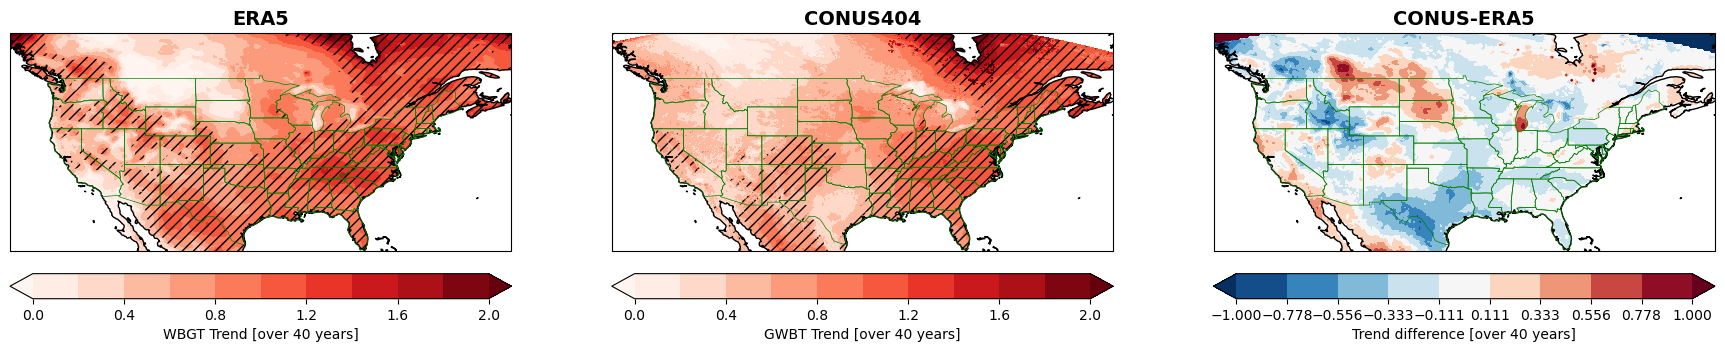

In [7]:
plot_hatches_p3(dir_o, n_year, 'mean', 1, vmin=0, vmax=2, n_level=11)

 - 1.3.2) Annual maximum increase over 40 years

/glade/campaign/mmm/c3we/mingge/DOD/WBGT_ERA5_annual_max_mk.nc
/glade/campaign/mmm/c3we/mingge/DOD/GWBT_CONUS404_annual_max_mk.nc
interpolate


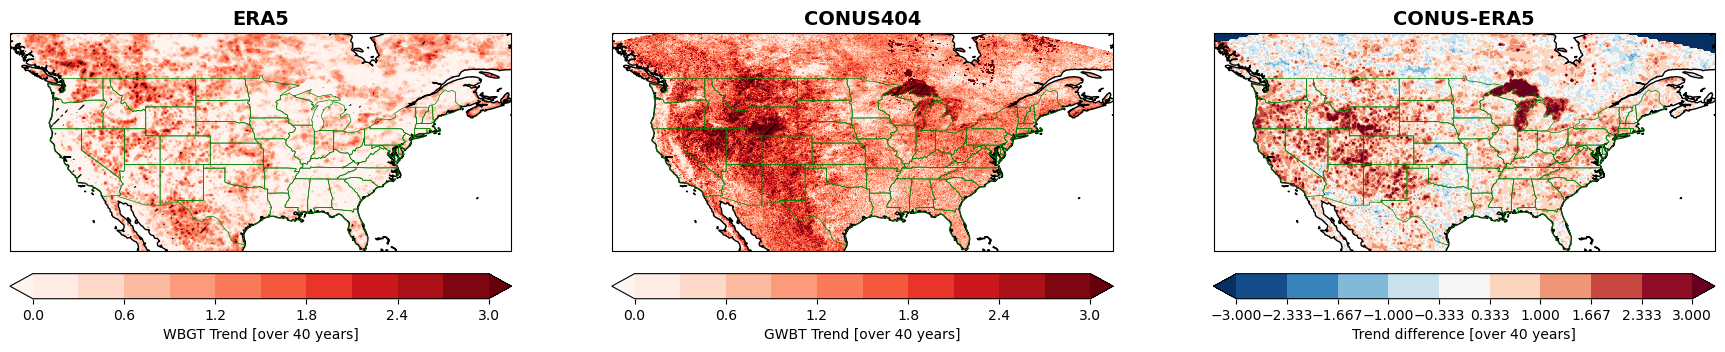

In [53]:
plot_hatches_p3(dir_o, n_year, 'max', 3, vmin=0, vmax=3, n_level=11)

#### 2) Fraction of training hours (9:00am-4:00pm UTC-7) excedding black flag.  
9:00 - 16 -> UTC 16-23 

In [8]:
tbf = 305.372  # 90F -> K
hr_s = 16 
hr_e = 23 + 1  # exclude
n_month = 12
n_hour = 24

- 2.1) annual monthly number of hours above TBF - ERA5

In [9]:
var_s = 'WBGT'

year_s = 1980
year_e = 2019
n_year = year_e - year_s + 1

flnm_o = dir_o + var_s + '_ERA5_yyyymm_TBFhour_training.nc'

if os.path.exists(flnm_o):
    print(flnm_o, 'exist')
    with xr.open_dataset(flnm_o) as ds:
        n_tbf_e = ds.n_TBF.sum(dim='month').mean(dim='year')
else: 
    data_4d = np.zeros((n_year, n_month, n_lat_era5, n_lon_era5))
    dir_i = dir_o + var_s + '_ERA5_HOURLY/'
    for year in range(year_s, year_e + 1):
        for month in range(1, 12 + 1):
            flnm = dir_i + var_s + '_' + str(year)+ str(month).zfill(2) + '_ERA5_hourly.nc'
            with xr.open_dataset(flnm) as ds:
                print(flnm)
                data_d = ds[var_s][:,hr_s:hr_e]    
                data_d = data_d - tbf 
                data_4d[year-year_s, month-1] = np.sum(data_d > 0,  axis=(0,1))
                
    da = xr.DataArray(data = data_4d,
                    coords = {'year': range(year_s, year_e + 1),
                              'month':range(1,13,1), 
                              'latitude': ds.latitude, 
                              'longitude': ds.longitude}, 
                    dims = ["year", "month", "latitude", "longitude"],
                    attrs = {'script':'Ming Ge: wgbt_wrf_era5_cmp_2.ipynb',
                            'training time':'9am-4pm Arizonal time MST'})          
        
    # create and write out dataset 
    ds = da.to_dataset(name = 'n_TBF' )         
    ds.to_netcdf(flnm_o)
    print(flnm_o)      

/glade/campaign/mmm/c3we/mingge/DOD/WBGT_ERA5_yyyymm_TBFhour_training.nc exist


- 2.2) annual seasonal number of hours above TBF - WRF

In [10]:
var_s = 'GWBT'

data_4d = np.zeros((n_year, n_month, n_lat_conus, n_lon_conus))   
 
dir_i = '/glade/campaign/mmm/c3we/ESTCP/CONUS404/GWBT/'
flnm_o = dir_o + var_s + '_CONUS404_yyyymm_TBFhour_training.nc'
if os.path.exists(flnm_o):
    print(flnm_o, 'exist')
    with xr.open_dataset(flnm_o) as ds:
        n_tbf_c = ds.n_TBF.sum(dim='month').mean(dim='year')
else: 
    for year in range(year_s, year_e + 1):
        for month in range(1, 12 + 1):
            flnm = dir_i + 'GWBT_' + str(year)+ str(month).zfill(2) + '_CONUS404.nc'           
            with xr.open_dataset(flnm) as ds:
                print(flnm)
                data_0 = ds[var_s].values
                data_d = data_0.reshape((int(data_0.shape[0]/24), 24, n_lat_conus, n_lon_conus))
                data_t = data_d[:,hr_s:hr_e] - tbf 
                data_4d[year-year_s, month-1] = np.sum(data_t > 0,  axis=(0,1))
                
    da = xr.DataArray(data = data_4d,
                    coords = {'year': range(year_s, year_e +1,1),
                              'month': range(1, 13),
                              'lat': ds.lat, 
                              'lon': ds.lon}, 
                    dims = ["year", "month", "y", "x"],
                    attrs = {'script':'Ming Ge: wgbt_wrf_era5_cmp_2.ipynb',
                            'training time':'9am-4pm Arizonal time MST'})
                   
    # create and write out dataset 
    ds = da.to_dataset(name = 'n_TBF' )         
    ds.to_netcdf(flnm_o)
    print(flnm_o) 
         

/glade/campaign/mmm/c3we/mingge/DOD/GWBT_CONUS404_yyyymm_TBFhour_training.nc exist


flnm_e_old = dir_o + 'WBGT_ERA5_annual_TBFday_hourly.nc'
with xr.open_dataset(flnm_e_old) as ds:
    print(flnm_e_old)
    #n_tbf = ds.n_TBF[:,hr_s:hr_e].mean(dim='year').sum(dim='hour')
    n_tbf_24 = ds.n_TBF.mean(dim='year').sum(dim='hour')
    n_tbf_24.plot()

- 2.3.1) Annual average number of  training hours (9:00-16:00 MST)  exceed Black Flag during

Annual average number of hours exceed Black Flag during training hours (9:00-16:00 MST)


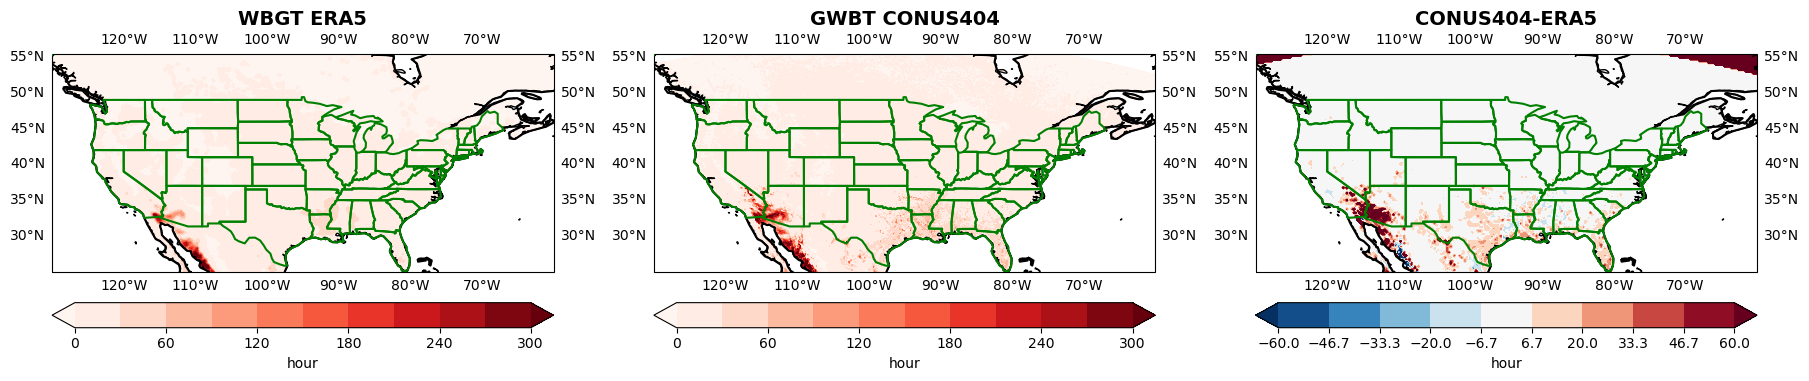

In [40]:
#interpolate WRF conus to ERA5 grid
lon_2d, lat_2d = np.meshgrid(lon_era5, lat_era5)
points = np.array([lon_conus.flatten(), lat_conus.flatten()]).transpose()
vtx, wts = interp_weights(points, np.append(lon_2d.flatten()[:,None], lat_2d.flatten()[:,None], axis=1)) 

valuesi=interpolate(n_tbf_c.values.flatten(), vtx, wts)
data_c = valuesi.reshape(lat_2d.shape[0], lat_2d.shape[1])

n_tbf_d = (data_c - n_tbf_e)
# get rid of missing data of interpolated CONUS 404
#n_tbf_d = n_tbf_d.where(abs(data_d)<4)

data_dif = xr.DataArray(n_tbf_d, 
                    coords={'latitude': lat_era5, 
                            'longitude': lon_era5},
                    dims=['latitude', 'longitude'])    

print('Annual average number of hours exceed Black Flag during training hours (9:00-16:00 MST)')
color_1d = ['Reds', 'Reds', 'RdBu_r']    
title_1d = ['WBGT ERA5', 'GWBT CONUS404', 'CONUS404-ERA5']
plot_cartopy_p3(lat_era5, lon_era5, n_tbf_e, lat_conus, lon_conus, n_tbf_c, data_dif, title_1d, 0, 300, 11, 60, color_1d, 'hour')

 - 2.3.2) Annual average fraction of training hours (9:00-16:00 MST) exceed Black Flag 

Annual average fraction of training hours exceed BF


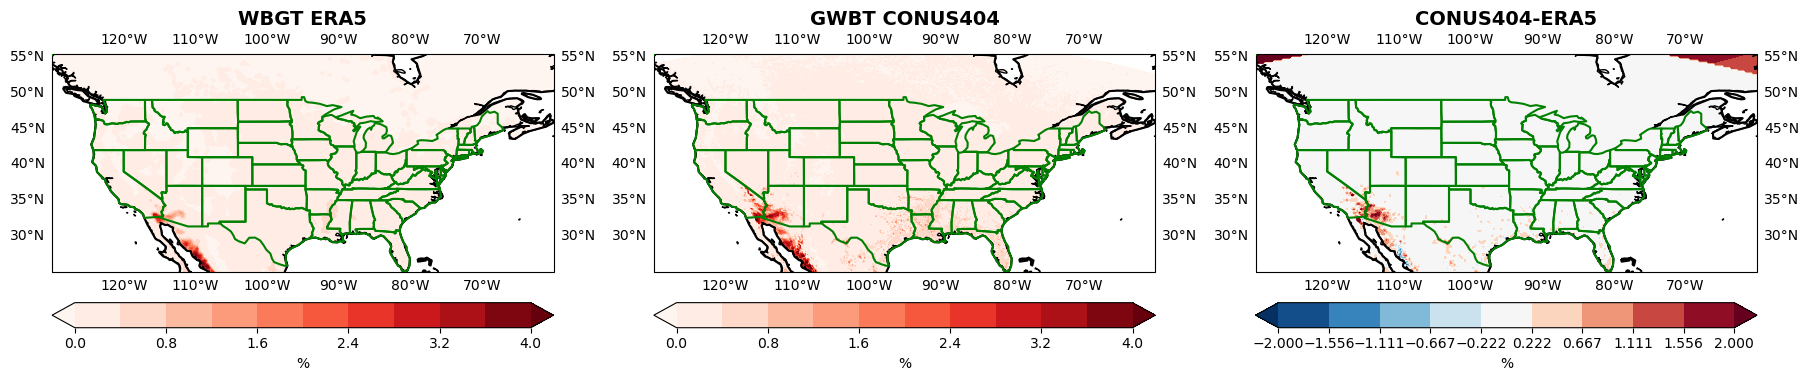

In [18]:
print('Annual average fraction of training hours exceed BF')
perc = 100/(365*24)
plot_cartopy_p3(lat_era5, lon_era5, n_tbf_e*perc, lat_conus, lon_conus, n_tbf_c*perc, data_dif*perc, title_1d, 0, 4, 11, 2, color_1d, '%')

- 3) Trend of training hours varied in U.S.  

In [24]:
flnm_e = dir_o + 'WBGT_ERA5_yyyymm_TBFhour_training.nc' 
flnm_o = dir_o + 'WBGT_ERA5_annual_TBFhour_training_mk.nc'

if os.path.exists(flnm_o):
    print(flnm_o, 'exist')
    with xr.open_dataset(flnm_o) as ds:
        #print(ds)
        data_3d = ds.n_TBF
        lat_era5 = ds.latitude.values
        lon_era5 = ds.longitude.values
        n_lat_era5 = data_3d.shape[1]
        n_lon_era5 = data_3d.shape[2]
else:
    with xr.open_dataset(flnm_e) as ds:
        #print(ds,flnm_e)
        data_3d = ds['n_TBF'].sum(dim='month')
        n_year = data_3d.shape[0]
        n_lat_era5 = data_3d.shape[1]
        n_lon_era5 = data_3d.shape[2]
    
        #slope_2d = np.zeros((n_lat_era5, n_lon_era5))  
        mk_3d = np.zeros((2, n_lat_era5, n_lon_era5)) 
        for ni in range(n_lat_era5):
            print(ni)
            for nj in range(n_lon_era5):
                res = mk.original_test(data_3d[:,ni, nj])
                #slope_2d[ni, nj] = np.polyfit(range(data_3d.shape[0]), data_3d[:,ni, nj],1)[0]
                mk_3d[0, ni, nj] = res.p
                mk_3d[1, ni, nj] = res.slope
         
        da = xr.DataArray(data = mk_3d,
                          coords={'mk': range(2), 'latitude': ds.latitude, 'longitude': ds.longitude}, 
                          dims=["mk", "latitude", "longitude"],
                          attrs = {'mk':'0:p_value, 1:slope', 'script':'Ming Ge: wgbt_wrf_era5_cmp_2.ipynb' })
                    
        ds = da.to_dataset(name='n_TBF')         
        ds.to_netcdf(flnm_o)
        print(flnm_o)   
print('finished')     

/glade/campaign/mmm/c3we/mingge/DOD/WBGT_ERA5_annual_TBFhour_training_mk.nc exist
finished


In [26]:
flnm_c = dir_o + 'GWBT_CONUS404_yyyymm_TBFhour_training.nc' 
flnm_o = dir_o + 'GWBT_CONUS404_annual_TBFhour_training_mk.nc'

if os.path.exists(flnm_o):
    print(flnm_o, 'exist')
    with xr.open_dataset(flnm_o) as ds:
        print(flnm_o)
        data_3d = ds['n_TBF']
        lat_conus = ds.lat.values
        lon_conus = ds.lon.values
        n_lat_conus  = data_3d.shape[1]
        n_lon_conus  = data_3d.shape[2]
else:
    with xr.open_dataset(flnm_c) as ds:
        #print(ds,flnm_i)
        data_3d = ds['n_TBF'].sum(dim='month')
        n_year = data_3d.shape[0]     
        n_lat_conus  = data_3d.shape[1]
        n_lon_conus  = data_3d.shape[2]
        
        mk_3d = np.zeros((2, n_lat_conus, n_lon_conus)) 
        for ni in range(n_lat_conus):
            print(ni)
            for nj in range(n_lon_conus):
                res = mk.original_test(data_3d[:,ni, nj])
                #slope_2d[ni, nj] = np.polyfit(range(data_3d.shape[0]), data_3d[:,ni, nj],1)[0]
                mk_3d[0, ni, nj] = res.p
                mk_3d[1, ni, nj] = res.slope
         
        da = xr.DataArray(data = mk_3d,
                          coords={'mk': range(2), 'lat': ds.lat, 'lon': ds.lon}, 
                          dims=["mk", "y", "x"],
                          attrs = {'mk':'0:p_value, 1:slope', 'script':'Ming Ge: wgbt_wrf_era5_cmp_2.ipynb' })
                    
        ds = da.to_dataset(name='n_TBF')         
        ds.to_netcdf(flnm_o)
        print(flnm_o)   
print('finished')

/glade/campaign/mmm/c3we/mingge/DOD/GWBT_CONUS404_annual_TBFhour_training_mk.nc exist
/glade/campaign/mmm/c3we/mingge/DOD/GWBT_CONUS404_annual_TBFhour_training_mk.nc
finished


Training hours (exceeding BF) increase over 40 years
/glade/campaign/mmm/c3we/mingge/DOD/WBGT_ERA5_annual_TBFhour_training_mk.nc
/glade/campaign/mmm/c3we/mingge/DOD/GWBT_CONUS404_annual_TBFhour_training_mk.nc
interpolate


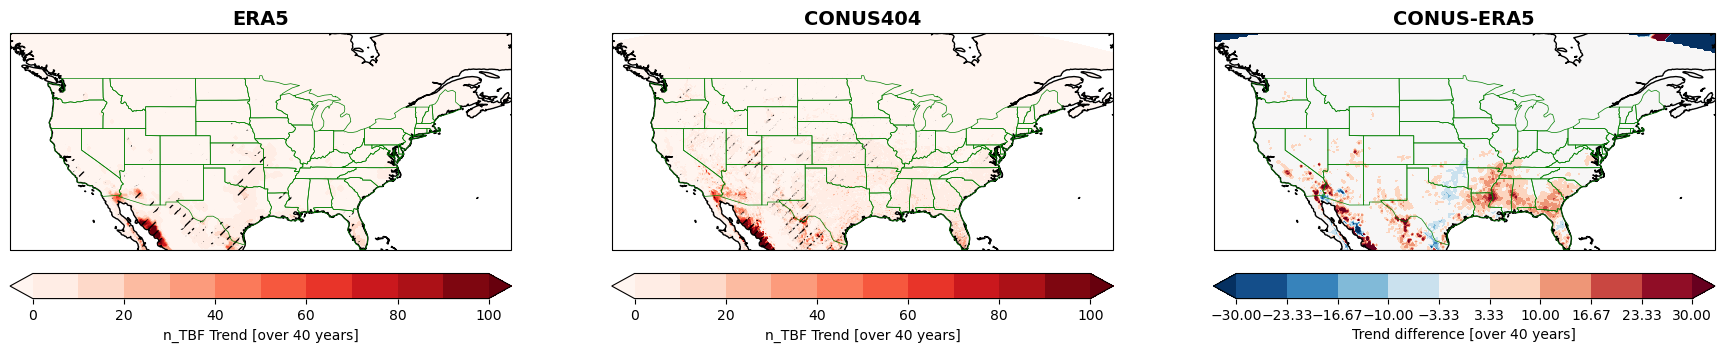

In [37]:
print('Training hours (exceeding BF) increase over 40 years')
plot_hatches_p3(dir_o, n_year, 'TBFhour_training', 30, vmin=0, vmax=100, n_level=11)

####  4) Monthly ( May to Oct ) training hours exceeding BF and its trend
- 4.1) Annual average number of training hours (9:00-16:00 MST) exceed Black Flag 

/glade/campaign/mmm/c3we/mingge/DOD/WBGT_ERA5_yyyymm_TBFhour_training.nc
/glade/campaign/mmm/c3we/mingge/DOD/GWBT_CONUS404_yyyymm_TBFhour_training.nc
Annual average number of hours exceed Black Flag during training hours (9:00-16:00 MST)
Annual average number of hours exceed Black Flag during training hours (9:00-16:00 MST)
Annual average number of hours exceed Black Flag during training hours (9:00-16:00 MST)
Annual average number of hours exceed Black Flag during training hours (9:00-16:00 MST)
Annual average number of hours exceed Black Flag during training hours (9:00-16:00 MST)
Annual average number of hours exceed Black Flag during training hours (9:00-16:00 MST)


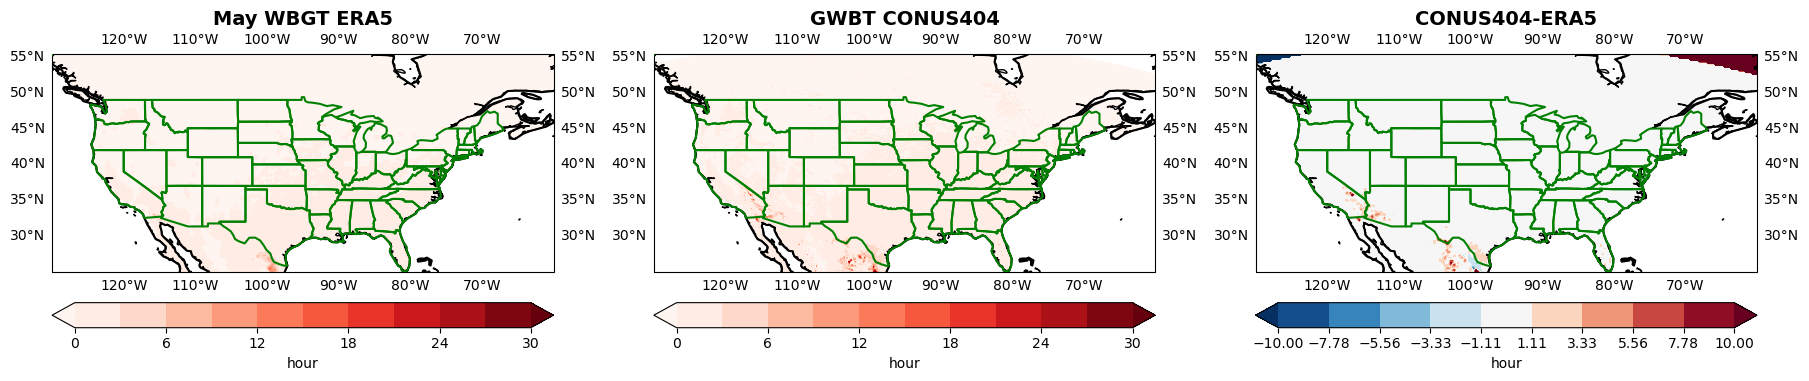

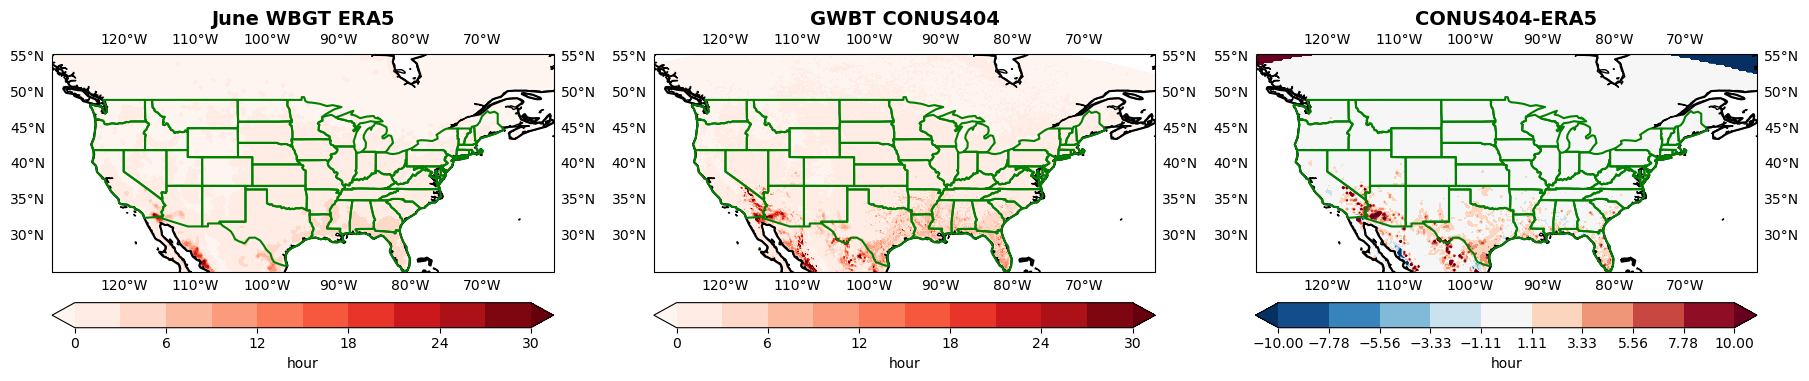

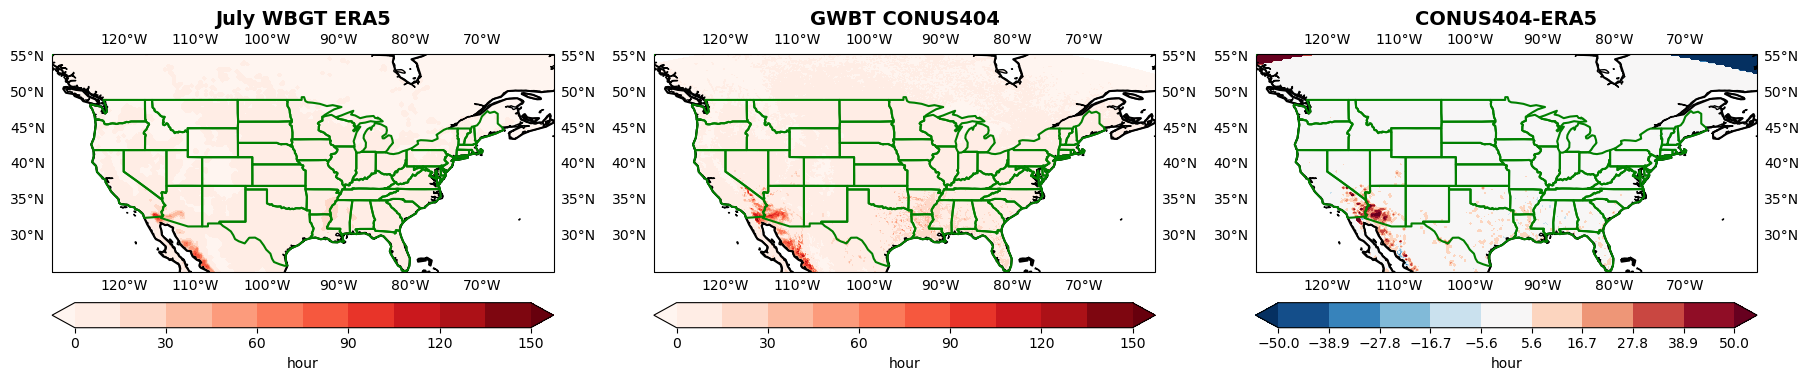

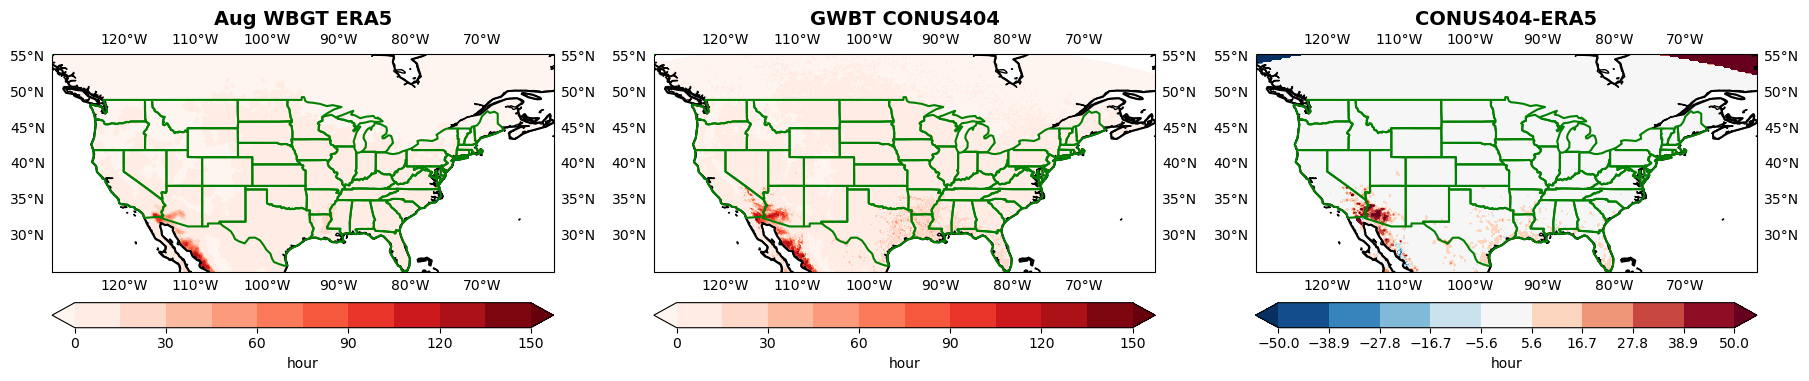

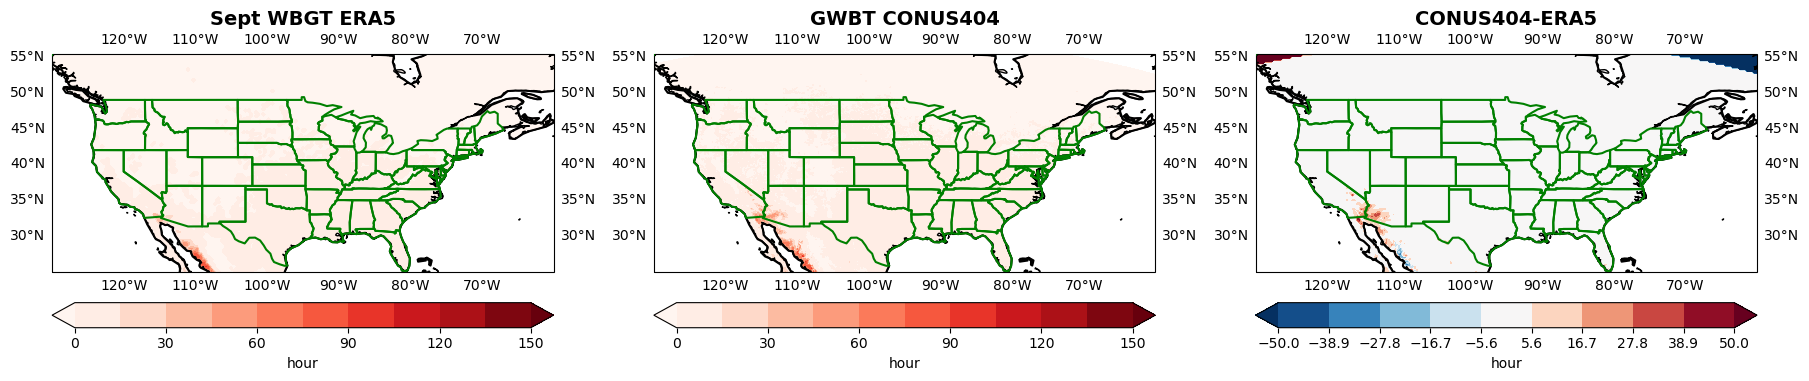

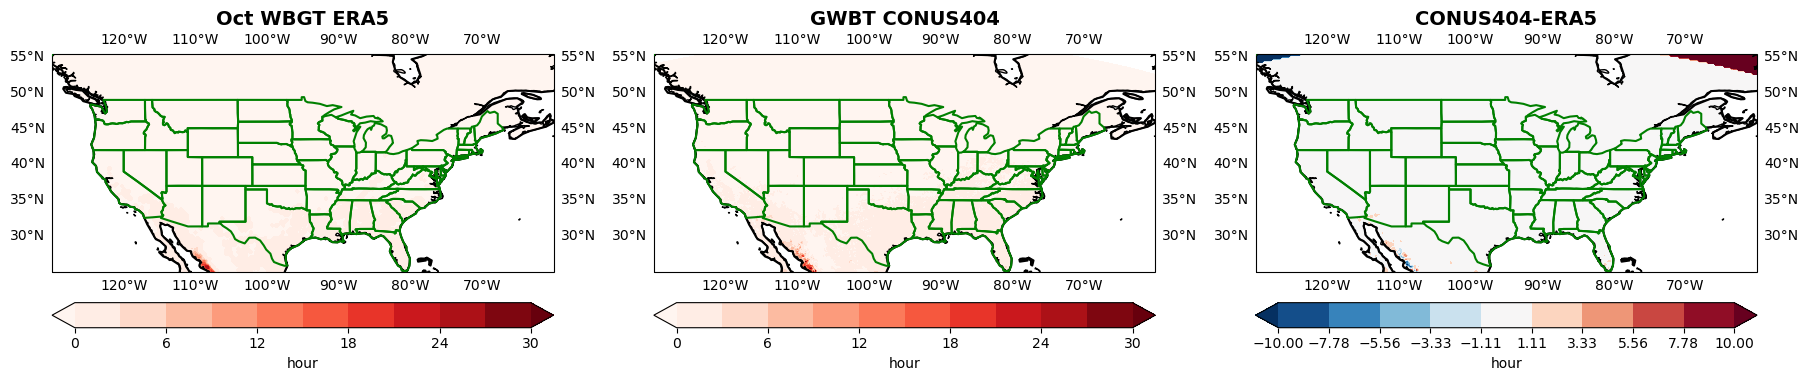

In [41]:
flnm_e = dir_o + 'WBGT_ERA5_yyyymm_TBFhour_training.nc'
if os.path.exists(flnm_e):
    print(flnm_e)
    with xr.open_dataset(flnm_e) as ds:
        n_tbf_e_3d = ds.n_TBF.mean(dim='year')
 
flnm_c = dir_o + 'GWBT_CONUS404_yyyymm_TBFhour_training.nc'
if os.path.exists(flnm_c):
    print(flnm_c)
    with xr.open_dataset(flnm_c) as ds:
        n_tbf_c_3d = ds.n_TBF.mean(dim='year')


#interpolate WRF conus to ERA5 grid
#lon_2d, lat_2d = np.meshgrid(lon_era5, lat_era5)
#points = np.array([lon_conus.flatten(), lat_conus.flatten()]).transpose()
#vtx, wts = interp_weights(points, np.append(lon_2d.flatten()[:,None], lat_2d.flatten()[:,None], axis=1)) 

month_s = ['May','June','July','Aug','Sept','Oct',]
for month in range(4,10):
    n_tbf_e = n_tbf_e_3d[month]
    n_tbf_c = n_tbf_c_3d[month]
    valuesi=interpolate(n_tbf_c.values.flatten(), vtx, wts)
    data_c = valuesi.reshape(lat_2d.shape[0], lat_2d.shape[1])

    n_tbf_d = (data_c - n_tbf_e)
    # get rid of missing data of interpolated CONUS 404
    #n_tbf_d = n_tbf_d.where(abs(data_d)<4)

    data_dif = xr.DataArray(n_tbf_d, 
                    coords={'latitude': lat_era5, 
                            'longitude': lon_era5},
                    dims=['latitude', 'longitude'])    

    print('Annual average number of hours exceed Black Flag during training hours (9:00-16:00 MST)')
    color_1d = ['Reds', 'Reds', 'RdBu_r']    
    title_1d = [month_s[month-4] +' WBGT ERA5', 'GWBT CONUS404', 'CONUS404-ERA5']
    if month == 6 or month == 7 or month == 8:
        plot_cartopy_p3(lat_era5, lon_era5, n_tbf_e, lat_conus, lon_conus, n_tbf_c, data_dif, title_1d, 0, 150, 11, 50, color_1d, 'hour')
    else:
        plot_cartopy_p3(lat_era5, lon_era5, n_tbf_e, lat_conus, lon_conus, n_tbf_c, data_dif, title_1d, 0, 30, 11, 10, color_1d, 'hour')

- 4.2) Trend of annual average number of training hours (9:00-16:00 MST) exceed Black Flag during

In [12]:
flnm_e = dir_o + 'WBGT_ERA5_yyyymm_TBFhour_training.nc' 
flnm_o = dir_o + 'WBGT_ERA5_monthly_TBFhour_training_mk.nc'

# from May to Oct.
month_s = 5   
month_e = 10
n_month = month_e - month_s + 1

if os.path.exists(flnm_o):
    print(flnm_o, 'exist')
    with xr.open_dataset(flnm_o) as ds:
        print(ds)
        data_4d = ds.n_TBF
        lat_era5 = ds.latitude.values
        lon_era5 = ds.longitude.values
        n_lat_era5 = data_4d.shape[2]
        n_lon_era5 = data_4d.shape[3]
else:
    with xr.open_dataset(flnm_e) as ds:
        print(ds,flnm_e)
        data_4d = ds['n_TBF'][:, month_s-1: month_e]  #.sum(dim='month')
        n_year = data_4d.shape[0]
        n_lat_era5 = data_4d.shape[2]
        n_lon_era5 = data_4d.shape[3]
        mk_4d = np.zeros((n_month, 2, n_lat_era5, n_lon_era5)) 
    
        for nm in range(n_month): 
            print(nm)
            for ni in range(n_lat_era5):
                for nj in range(n_lon_era5):
                    res = mk.original_test(data_4d[:, nm, ni, nj])
                    mk_4d[nm, 0, ni, nj] = res.p
                    mk_4d[nm, 1, ni, nj] = res.slope
         
        da = xr.DataArray(data = mk_4d,
                          coords={'month':range(month_s, month_e+1),'mk': range(2), 'latitude': ds.latitude, 'longitude': ds.longitude}, 
                          dims=["month", "mk", "latitude", "longitude"],
                          attrs = {'mk':'0:p_value, 1:slope', 'script':'Ming Ge: wgbt_wrf_era5_cmp_2.ipynb' })
                    
        ds = da.to_dataset(name='n_TBF')         
        ds.to_netcdf(flnm_o)
        print(flnm_o)   
print('finished')     

/glade/campaign/mmm/c3we/mingge/DOD/WBGT_ERA5_monthly_TBFhour_training_mk.nc exist
<xarray.Dataset>
Dimensions:    (month: 6, mk: 2, latitude: 159, longitude: 326)
Coordinates:
  * month      (month) int64 5 6 7 8 9 10
  * mk         (mk) int64 0 1
  * latitude   (latitude) float32 57.25 57.0 56.75 56.5 ... 18.25 18.0 17.75
  * longitude  (longitude) float32 221.5 221.8 222.0 222.2 ... 302.2 302.5 302.8
Data variables:
    n_TBF      (month, mk, latitude, longitude) float64 ...
finished


In [13]:
flnm_c = dir_o + 'GWBT_CONUS404_yyyymm_TBFhour_training.nc' 
flnm_o = dir_o + 'GWBT_CONUS404_monthly_TBFhour_training_mk.nc'

# from May to Oct.
month_s = 5   
month_e = 10

if os.path.exists(flnm_o):
    print(flnm_o, 'exist')
    with xr.open_dataset(flnm_o) as ds:
        print(flnm_o)
        data_3d = ds['n_TBF']
        lat_conus = ds.lat.values
        lon_conus = ds.lon.values
        n_lat_conus  = data_3d.shape[1]
        n_lon_conus  = data_3d.shape[2]
else:
    with xr.open_dataset(flnm_c) as ds:
        #print(ds,flnm_i)
        data_4d = ds['n_TBF'][:, month_s-1: month_e] 
        n_year = data_4d.shape[0]  
        n_month = data_4d.shape[1]
        n_lat_conus  = data_4d.shape[2]
        n_lon_conus  = data_4d.shape[3]
        
        mk_4d = np.zeros((n_month, 2, n_lat_conus, n_lon_conus)) 
        for nm in range(n_month): 
            for ni in range(n_lat_conus):
                print(nm,ni)
                for nj in range(n_lon_conus):
                    res = mk.original_test(data_4d[:, nm, ni, nj])
                    mk_4d[nm, 0, ni, nj] = res.p
                    mk_4d[nm, 1, ni, nj] = res.slope
         
        da = xr.DataArray(data = mk_4d,
                          coords={'month':range(month_s, month_e+1),'mk': range(2), 'lat': ds.lat, 'lon': ds.lon}, 
                          dims=["month", "mk", "y", "x"],
                          attrs = {'mk':'0:p_value, 1:slope', 'script':'Ming Ge: wgbt_wrf_era5_cmp_2.ipynb' })
                    
        ds = da.to_dataset(name='n_TBF')         
        ds.to_netcdf(flnm_o)
        print(flnm_o)   
print('finished')

/glade/campaign/mmm/c3we/mingge/DOD/GWBT_CONUS404_monthly_TBFhour_training_mk.nc exist
/glade/campaign/mmm/c3we/mingge/DOD/GWBT_CONUS404_monthly_TBFhour_training_mk.nc
finished


In [35]:
def plot_hatch(nv, var_s, model_s, data_s, data_p, lat_2d, lon_2d, vmin, vmax, n_level):
    '''
    var_s:'WBGT', 'GWBT'
    model_s: 'ERA5', 'CONUS404'
    nv: 1,2 or 3, part of 3-panel plot
    '''
    #fig = plt.figure(figsize=(22, 10))
    levels = np.linspace(vmin, vmax, n_level) 
    #cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, "pad" : .05, 'aspect':40, 'label':'2 Metre Temperature Anomaly [K]'}

    # A p -value less than 0.05 (typically ≤ 0.05) 
    n_year = 40
    ax = fig.add_subplot(1, 3, nv, projection= ccrs.PlateCarree())
    ax.set_extent([-130, -60, 25, 50])
    mm = plt.contourf(lon_2d, lat_2d, data_s*(n_year-1), 
                      cmap = 'Reds', extend='both',
                      vmin = vmin, vmax = vmax, levels = levels,
                      transform=ccrs.PlateCarree())
    
    # hatching <0.05
    plt.contourf(lon_2d, lat_2d, data_p, levels=[-99, 0.05, 99],
                    colors='none', hatches=['///', '']) #, alpha=.5)
    ax.coastlines()
    
    ax.add_feature(cfeature.STATES.with_scale('110m'), zorder=3, linewidth=0.5, edgecolor='g')
    # mask ocean 
    ax.add_feature(cfeature.OCEAN, facecolor='white', zorder=1)
    cbar = plt.colorbar(mm, orientation='horizontal', pad=0.03, extend='both')
    cbar.set_label(var_s + ' Trend [over 40 years]')
    plt.title(model_s, fontweight="bold", fontsize=14)
 
    

/glade/campaign/mmm/c3we/mingge/DOD/WBGT_ERA5_monthly_TBFhour_training_mk.nc
/glade/campaign/mmm/c3we/mingge/DOD/GWBT_CONUS404_monthly_TBFhour_training_mk.nc


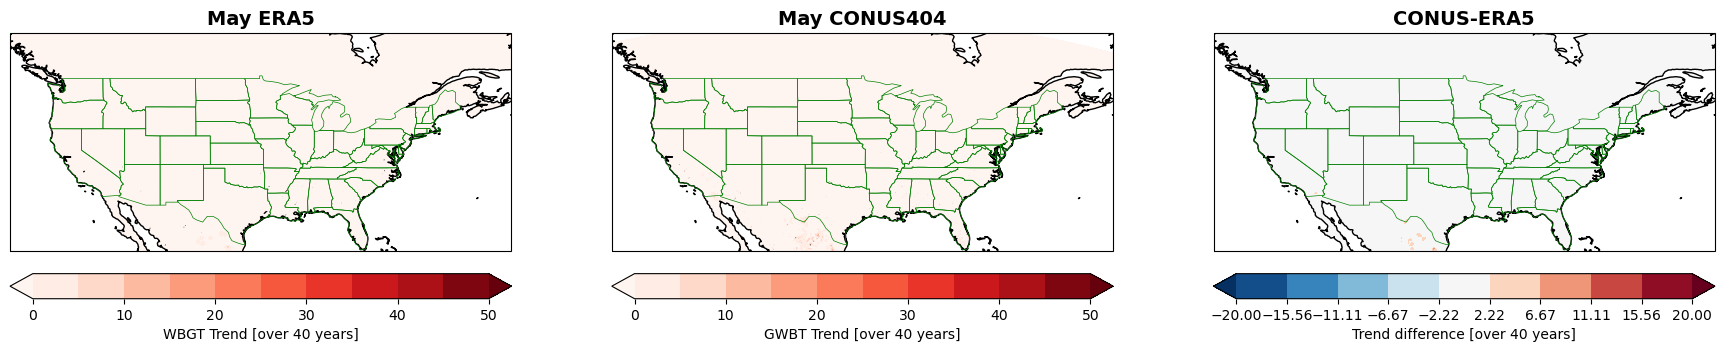

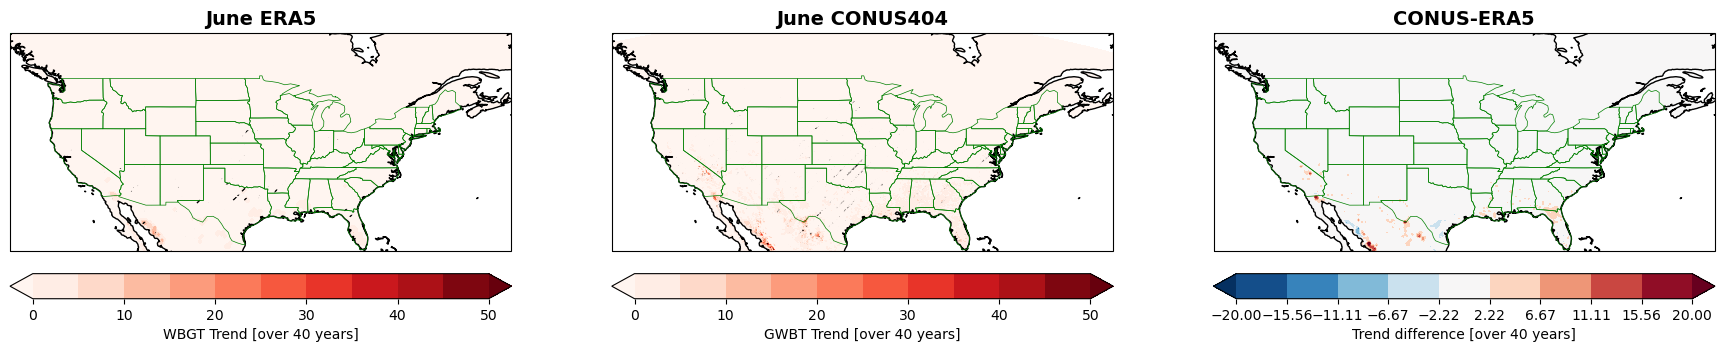

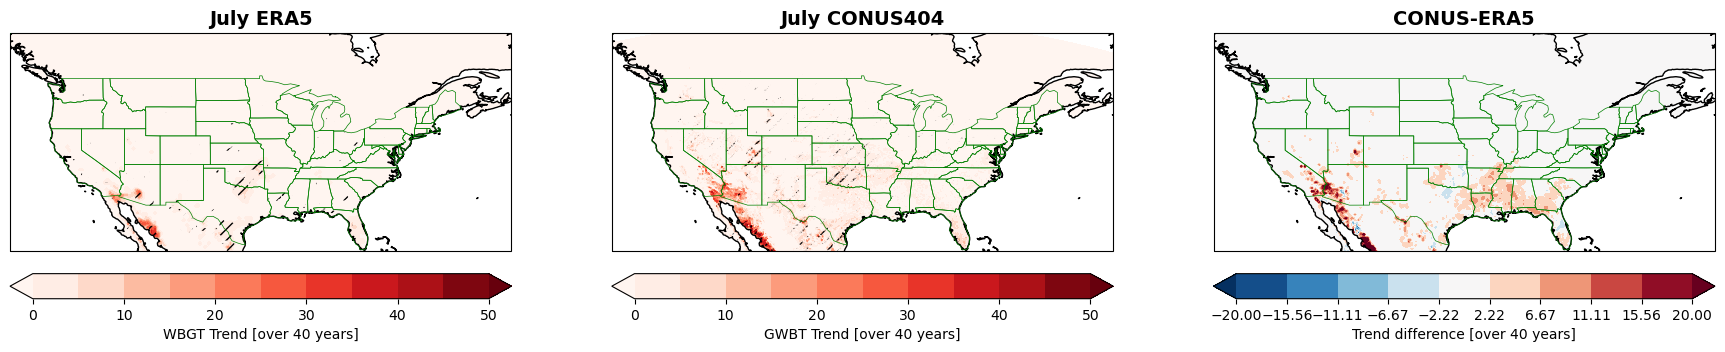

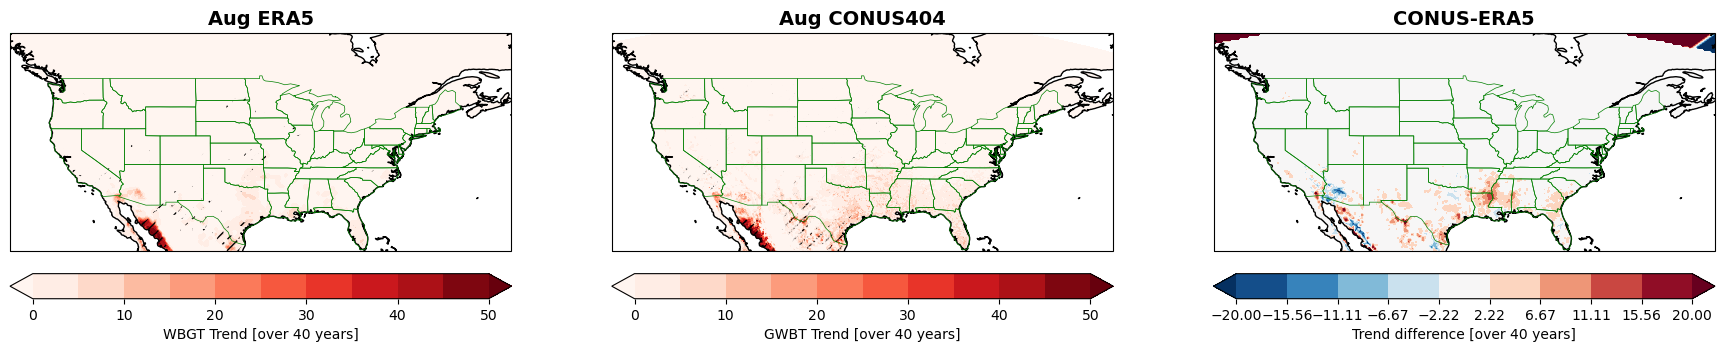

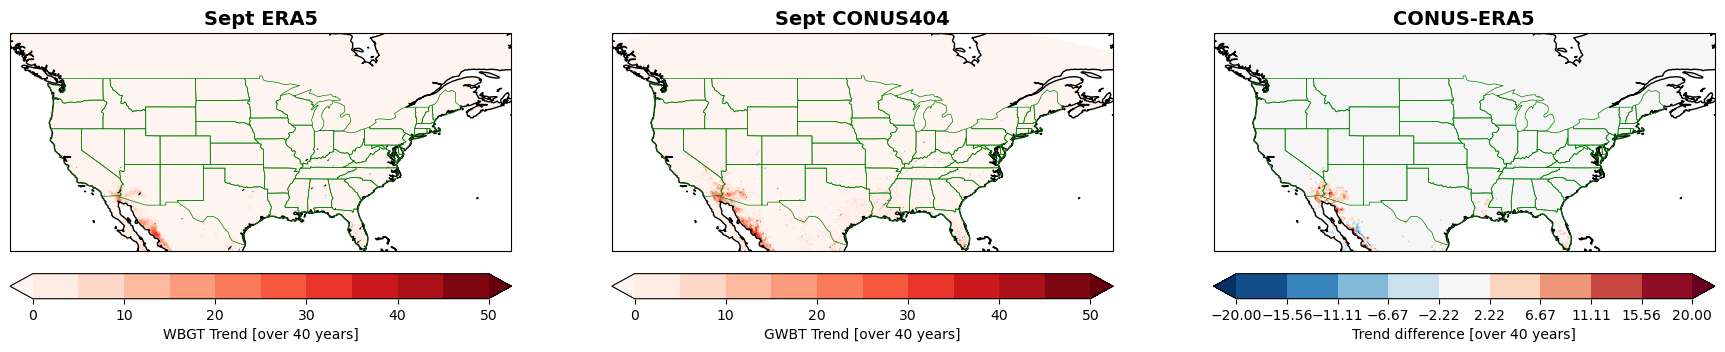

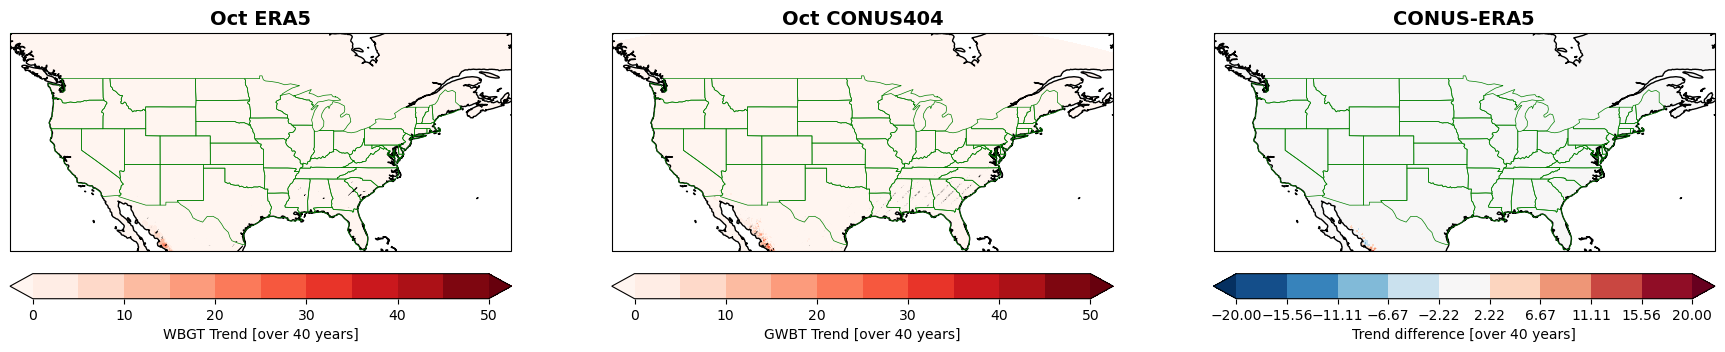

In [50]:
vmin = 0
vmax = 50
n_level = 11

cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, "pad" : .05, 'aspect':40, 'label':'2 Metre Temperature Anomaly [K]'}

    
flnm_e = dir_o + 'WBGT_ERA5_monthly_TBFhour_training_mk.nc'
if os.path.exists(flnm_e):
    print(flnm_e)
    with xr.open_dataset(flnm_e) as ds_e:
        n_tbf_e_p_3d = ds_e.n_TBF[:,0]
        n_tbf_e_s_3d = ds_e.n_TBF[:,1].values
        n_month = n_tbf_e_p_3d.shape[0]
 
flnm_c = dir_o + 'GWBT_CONUS404_monthly_TBFhour_training_mk.nc'
if os.path.exists(flnm_c):
    print(flnm_c)
    with xr.open_dataset(flnm_c) as ds_c:
        n_tbf_c_p_3d = ds_c.n_TBF[:,0]
        n_tbf_c_s_3d = ds_c.n_TBF[:,1]

month_s = ['May','June','July','Aug','Sept','Oct',]
for month in range(n_month):
    fig = plt.figure(figsize=(22, 10))

    n_tbf_e_p = n_tbf_e_p_3d[month]
    n_tbf_e_s = n_tbf_e_s_3d[month]
    n_tbf_c_p = n_tbf_c_p_3d[month]
    n_tbf_c_s = n_tbf_c_s_3d[month]
    
    plot_hatch(1, 'WBGT', month_s[month] + ' ERA5',     n_tbf_e_s, n_tbf_e_p, ds_e.latitude, ds_e.longitude, vmin, vmax, n_level)
    plot_hatch(2, 'GWBT', month_s[month] + ' CONUS404', n_tbf_c_s, n_tbf_c_p, ds_c.lat,      ds_c.lon,       vmin, vmax, n_level)
    
    valuesi = interpolate(n_tbf_c_s.values.flatten(), vtx, wts)
    data_c  = valuesi.reshape(n_lat_era5, n_lon_era5)

    n_tbf_d = (data_c - n_tbf_e_s)
    # get rid of missing data of interpolated CONUS 404
    #n_tbf_d = n_tbf_d.where(abs(data_d)<4)

    data_dif = xr.DataArray(n_tbf_d, 
                    coords={'latitude': lat_era5, 
                            'longitude': lon_era5},
                    dims=['latitude', 'longitude'])    

    vabs = 20
    ax = fig.add_subplot(1, 3, 3, projection= ccrs.PlateCarree())
    ax.set_extent([-130, -60, 25, 50])
    mm = plt.contourf(lon_era5, lat_era5, data_dif*(n_year-1), 
                      cmap = 'RdBu_r', extend='both',
                      vmin = -1*vabs, vmax = vabs, levels=np.linspace(-1*vabs, vabs, 10) ,
                      transform=ccrs.PlateCarree())
    
    ax.coastlines() 
    #ax.coastlines(lw=0.5, resolution='110m')
    ax.add_feature(cfeature.STATES.with_scale('110m'), zorder=3, linewidth=0.5, edgecolor='g')
    # mask ocean 
    ax.add_feature(cfeature.OCEAN, facecolor='white', zorder=1)
    cbar = plt.colorbar(mm, orientation='horizontal', pad=0.03, extend='both')
    cbar.set_label('Trend difference [over 40 years]')
    plt.title('CONUS-ERA5', fontweight="bold", fontsize=14)
    plt.show()  
    

#### 5) Future changes (1980-1989 currently)

In [51]:
year_s = 1980
year_e = 1989
n_year = year_e - year_s + 1
method = ['mean', 'max']
senariao = ['current', 'future']
dir_cf = '/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData_PGW/GWBT/'

In [ ]:
 GWBT_198501_CONUS404.nc

##### trend: tells the trend (increasing, decreasing or no trend)
- h: True (if trend is present) or False (if the trend is absence)
- p: p-value of the significance test
- z: normalized test statistics
- Tau: Kendall Tau
- s: Mann-Kendal's score
- var_s: Variance S
- slope: Theil-Sen estimator/slope
- intercept: intercept of Kendall-Theil Robust Line, for seasonal test, full period cycle consider as unit time step

https://www.guillaumedueymes.com/post/mann_kendall/

https://stackoverflow.com/questions/46856314/using-mann-kendall-in-python-with-a-lot-of-data


0.004462976655192663


Mann_Kendall_Test(trend='no trend', h=False, p=0.3908282308519908, z=0.8581163303210331, Tau=0.10158730158730159, s=64.0, var_s=5390.0, slope=0.004462976655192663, intercept=0.48413469790186153)

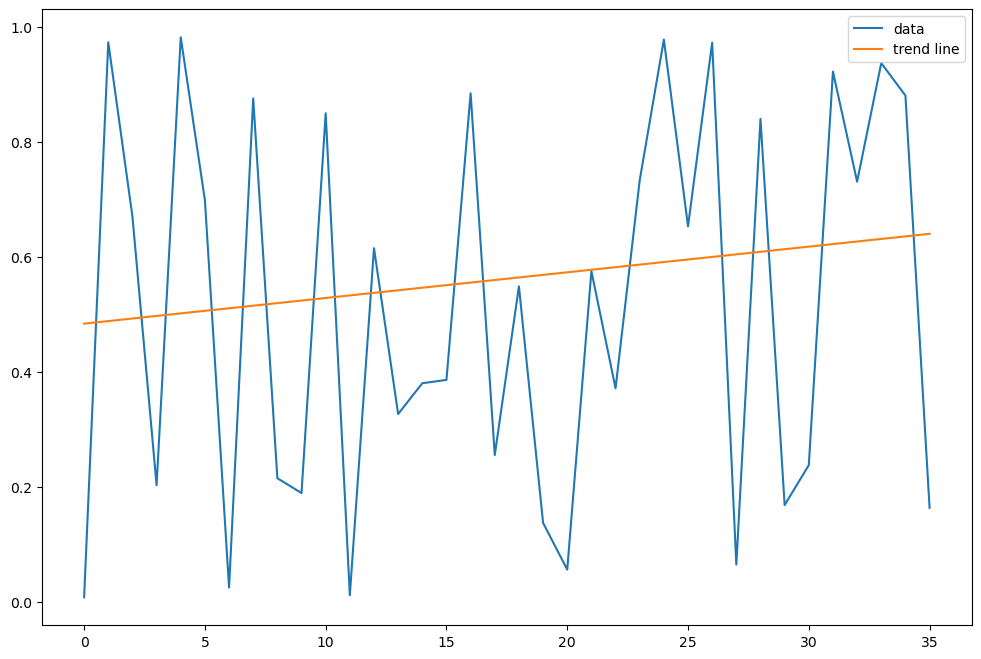

In [56]:
import numpy as np
import pymannkendall as mk
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))

# Data generation for analysis
data = np.random.rand(36,1)

res = mk.original_test(data)
# res = mk.trend_free_pre_whitening_modification_test(data)
trend_line = np.arange(len(data)) * res.slope + res.intercept

ax.plot(data)
ax.plot(range(len(data)), trend_line)
ax.legend(['data', 'trend line'])

print(res.slope)
res

Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=8.56754240907825, Tau=1.0, s=630.0, var_s=5390.0, slope=1.0, intercept=0.0)

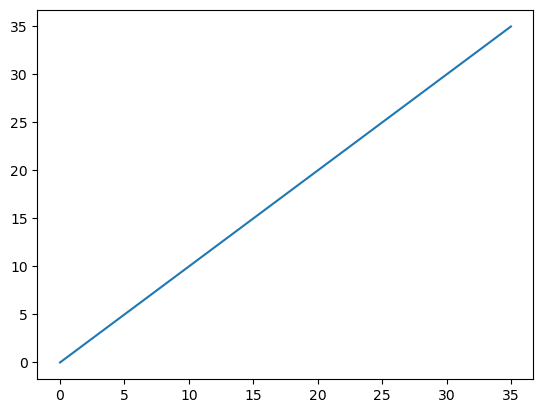

In [54]:
data = np.arange(36)
result = mk.original_test(data, alpha=0.05)
plt.plot(data)
result 

In [3]:
# the output is a named tuple, it can be called by name for specific result:
print(result.slope)

3.310535185083414e-05


In [4]:
# directly unpack your results:
trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test(data)

In [5]:
trend

'no trend'

In [ ]:
d = mk.original_test(df, alpha=0.05)
d